In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt


In [2]:
path = os.path.join('data', 'full_data', 'data.xlsx')
df = pd.read_excel(path)
# df = df.drop('Unnamed: 0', axis=1)
df.columns

Index(['text', 'joy_x', 'trust_x', 'anticipation_x', 'surprise_x', 'fear_x',
       'sadness_x', 'disgust_x', 'anger_x', 'valence_x', 'arousal_x'],
      dtype='object')

Text(0, 0.5, 'Count')

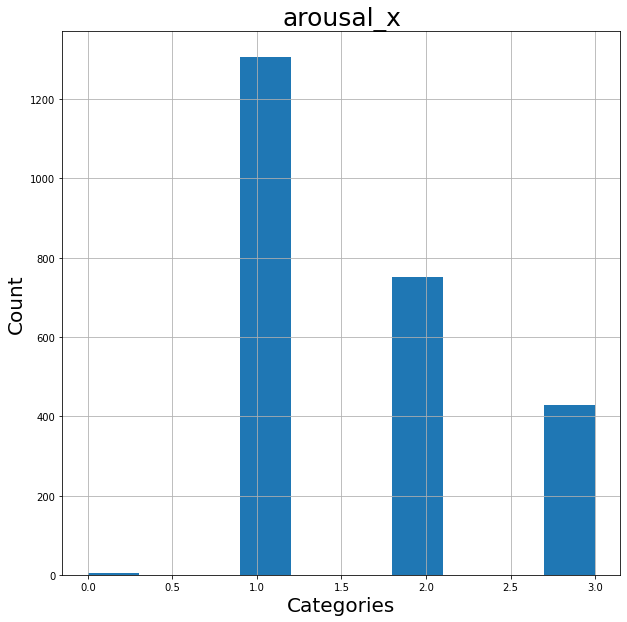

In [13]:
df['arousal_x'].hist(figsize=(10,10))
plt.title('arousal_x', fontsize=25)
plt.xlabel('Categories', fontsize=20)
plt.ylabel('Count', fontsize=20)


## Removing stop words

In [3]:
df.head(2)

text  joy_x  trust_x  \
0  If someone is looking for a quiet place to res...      0        0   
1  Unfortunately, I am very unhappy to see Mr. Ar...      0        0   

   anticipation_x  surprise_x  fear_x  sadness_x  disgust_x  anger_x  \
0               0           1       0          0          2        0   
1               0           0       0          2          0        2   

   valence_x  ...  joy_y  trust_y  anticipation_y  surprise_y  fear_y  \
0          1  ...      0        0               0           1       0   
1         -2  ...      0        0               0           0       1   

   sadness_y  disgust_y  anger_y  valence_y  arousal_y  
0          0          2        0          1          1  
1          2          0        2         -2          1  

[2 rows x 21 columns]

In [4]:
# Removing stop words
from nltk.corpus import stopwords
import nltk
import unicodedata
import re

stop = stopwords.words('english')

def basic_clean(text):
    """
    A simple function to clean up the data. All the words that
    are not designated as a stop word is then lemmatized after
    encoding and basic regex parsing are performed.
    """
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


df['cleaned_text'] = df['text'].apply(lambda x: ' '.join([word for word in basic_clean(x) if word not in (stop)]))


In [5]:
from collections import Counter
Counter(" ".join(df["cleaned_text"]).split()).most_common(10)

[('hotel', 628),
 ('doctor', 506),
 ('room', 431),
 ('time', 269),
 ('visit', 234),
 ('one', 218),
 ('nice', 202),
 ('also', 200),
 ('recommend', 195),
 ('year', 182)]

In [6]:
#nice library to produce wordclouds
from wordcloud import WordCloud

import matplotlib.pyplot as plt

def plot_word_cloud(possitive=True):
    n_rows = 5
    n_cols = 2
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(30, 30))

    columns = ['joy_x', 'trust_x', 'anticipation_x', 'surprise_x', 'fear_x',
        'sadness_x', 'disgust_x', 'anger_x', 'arousal_x', 'valence_x'] 

    for row in range(n_rows):
        for col in range(n_cols):
            c = columns[row * n_cols + col]
            
            if possitive:
                condition = ((df[c] > 0) & (df['valence_x'] > 0)) 
            else:
                if c != 'valence_x':
                    condition = ((df[c] > 0) & (df['valence_x'] <= 0))
                else:
                    condition = (df['valence_x'] <= 0)
            
            all_words = '' 
            #looping through all incidents and joining them to one text, to extract most common words
            for arg in df[condition]["cleaned_text"]: 

                tokens = arg.split()  
                
                all_words += " ".join(tokens)+" "

            wordcloud = WordCloud(collocation_threshold=2,
                              collocations=True
                              ).generate(str(all_words))
            
            # plot the WordCloud image
                                 
            axs[row, col].imshow(wordcloud)
            axs[row, col].set_title(columns[row * n_cols + col])
            axs[row, col].set_title(c)
            axs[row, col].axis("off")
  

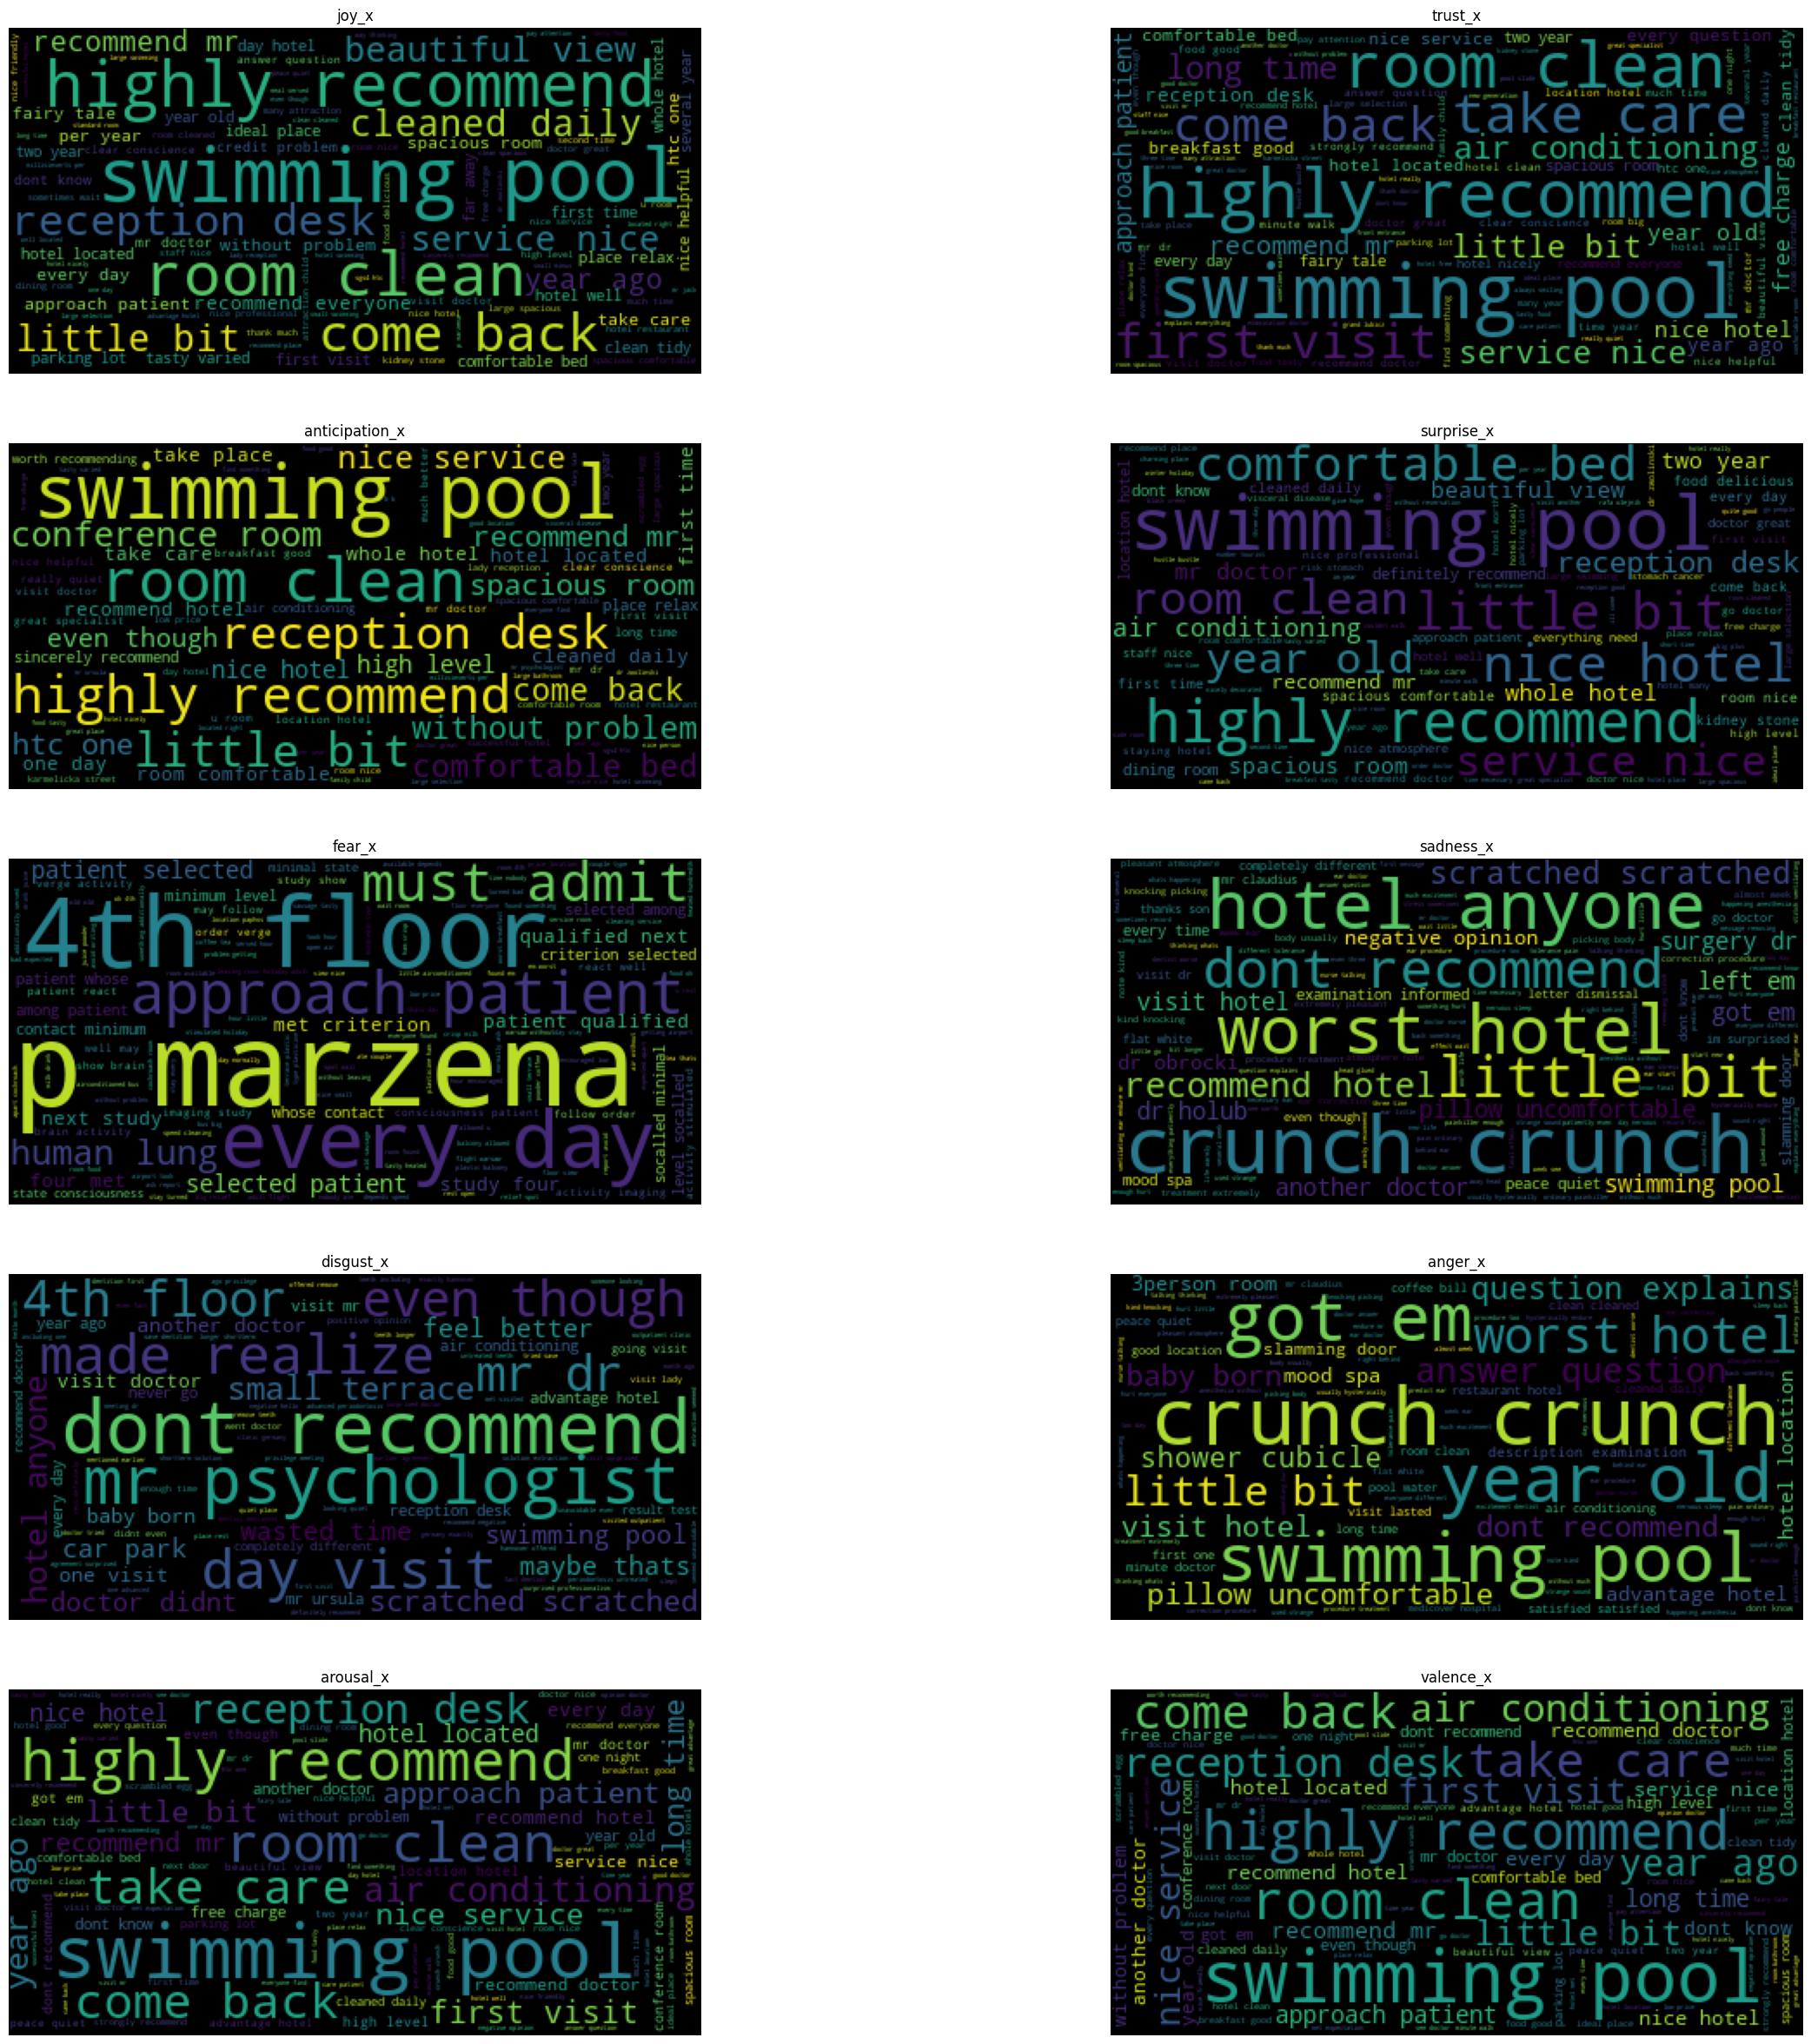

In [7]:
plot_word_cloud(possitive=True)

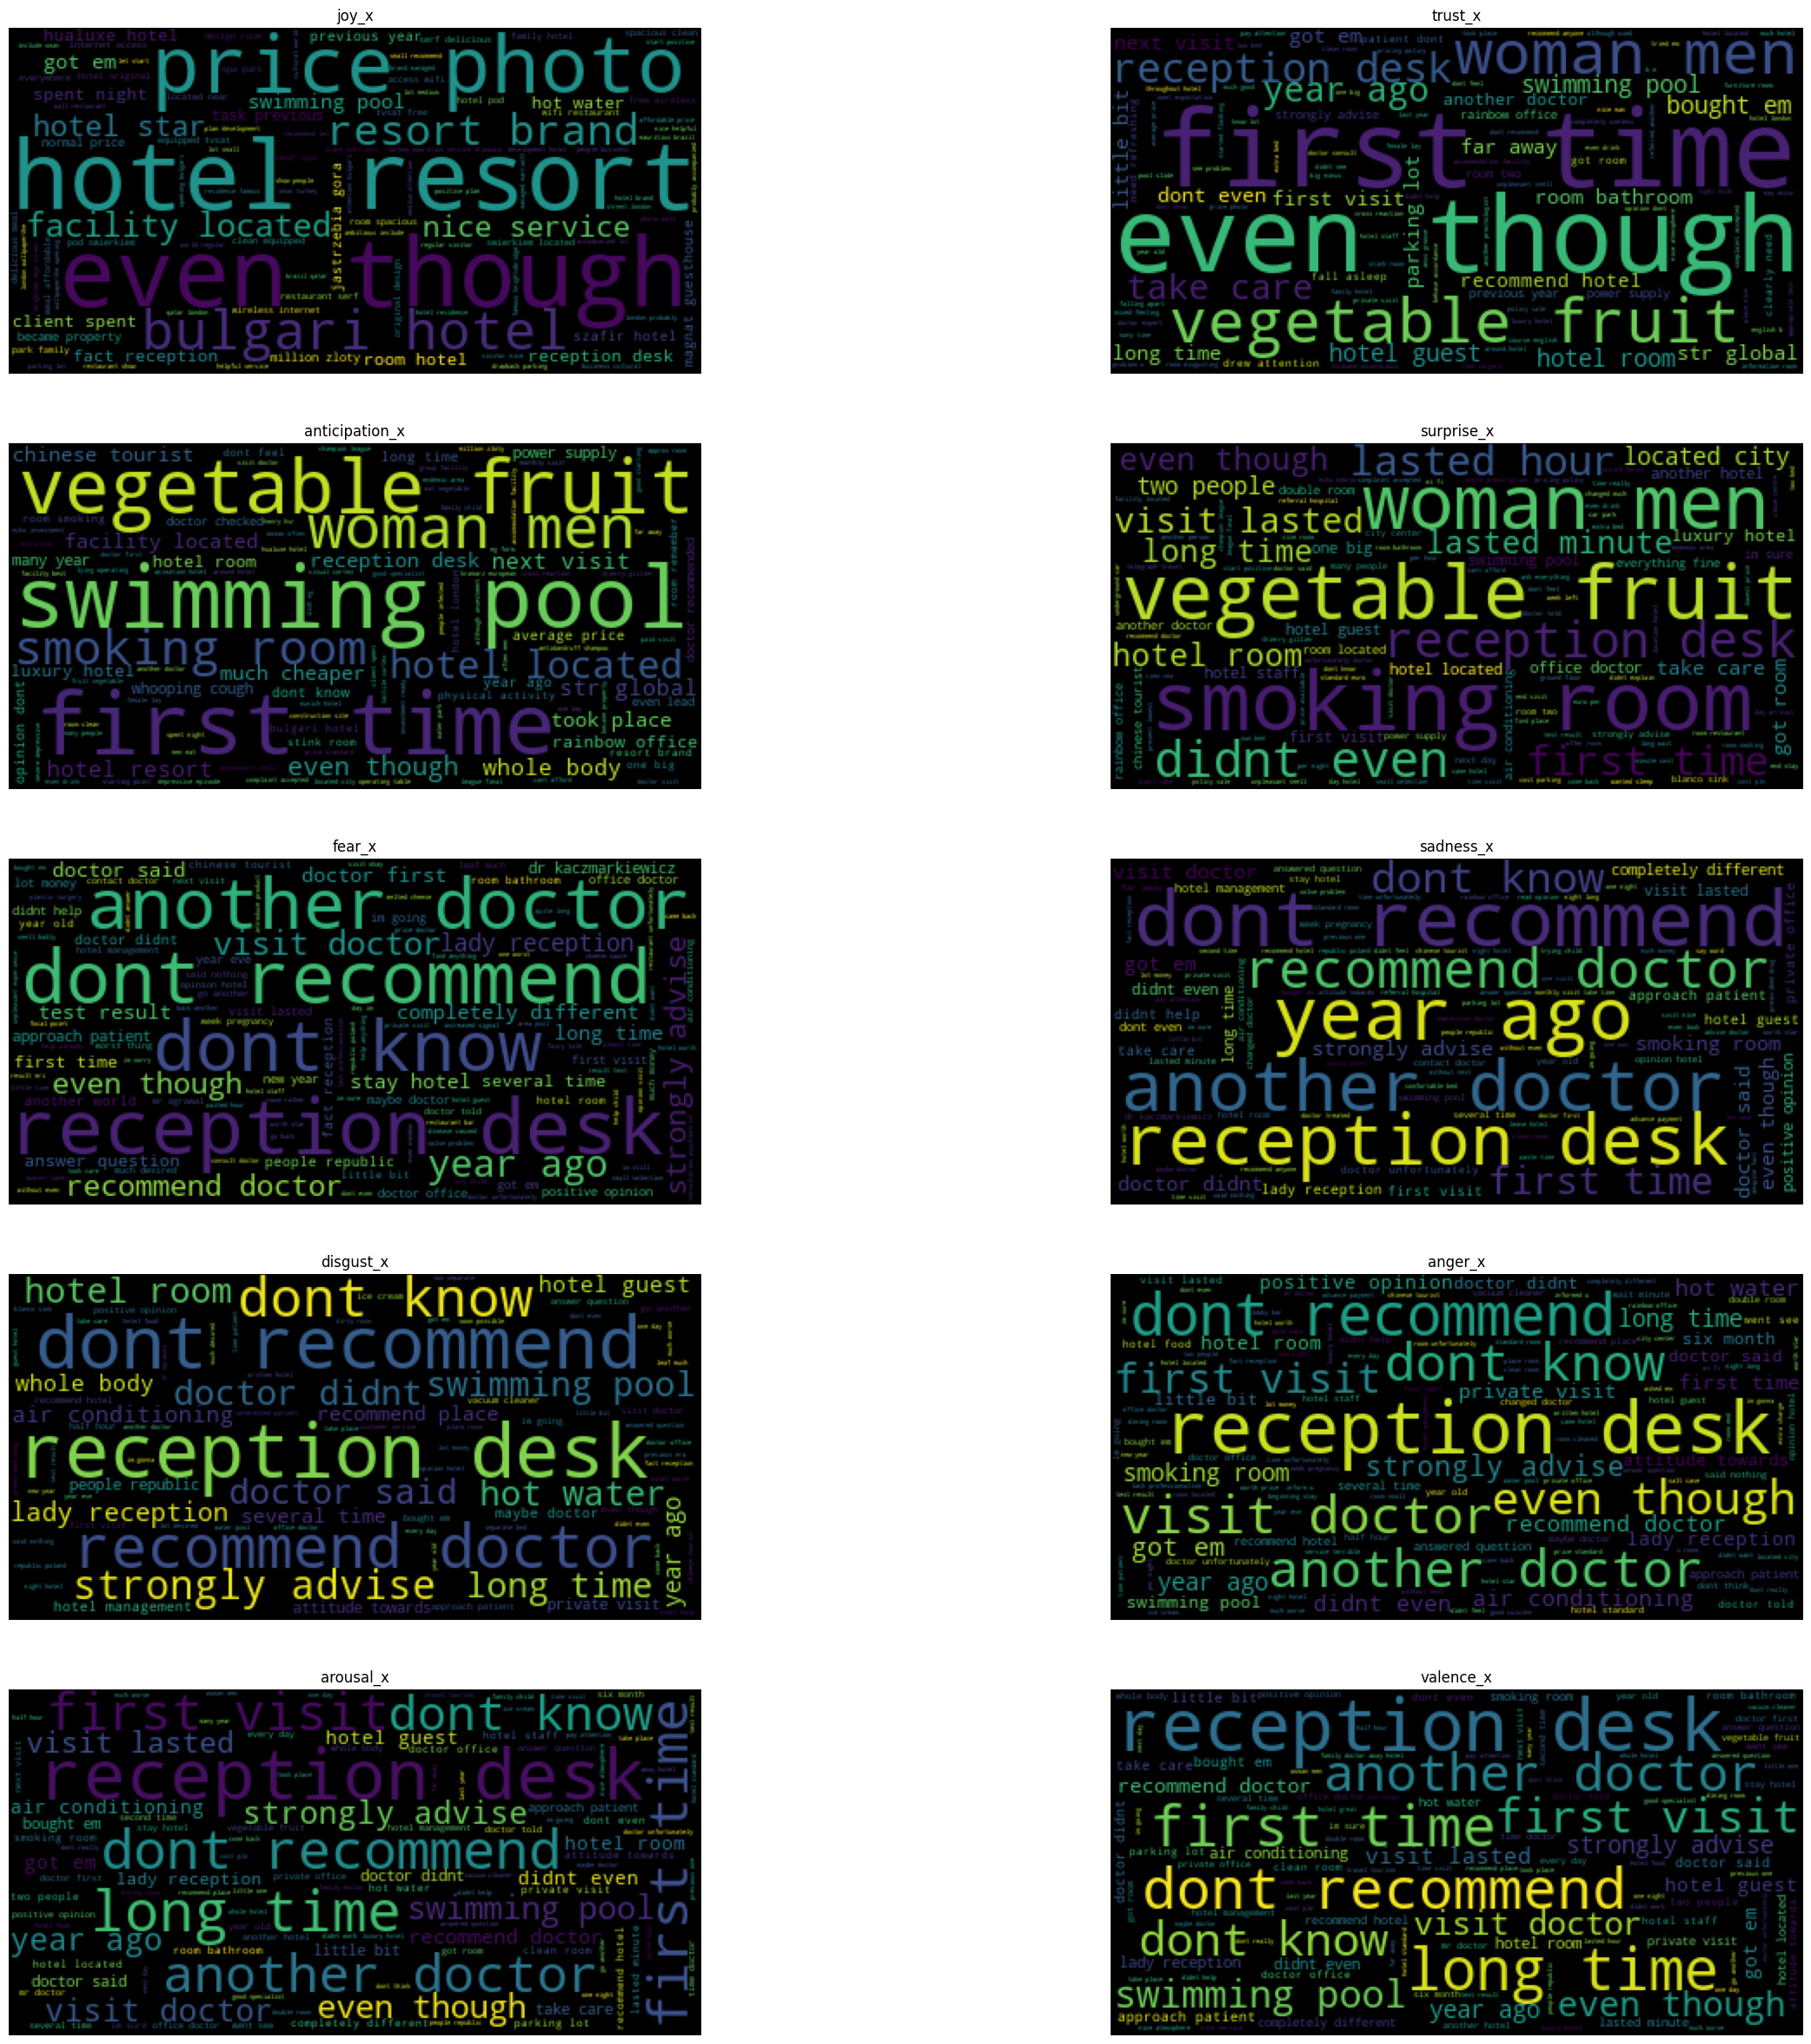

In [8]:
plot_word_cloud(possitive=False)

In [9]:
df['cleaned_text'] = df['text'].apply(lambda x: ' '.join([word for word in basic_clean(x) if word not in (stop)]))
df['cleaned_text_ngrams'] = df['cleaned_text'].apply(lambda x: x.split(' '))


In [10]:
condition = (df['valence_x'] < 0)
filtered_df = df[condition]
# filtered_df['bigrams'] = filtered_df['cleaned_text_ngrams'].apply(lambda x: list(nltk.ngrams(x, 2)))
words = basic_clean(''.join(str(df['cleaned_text'].tolist())))

In [11]:
from collections import Counter

def get_common_mentioned_bigrams(condition) -> pd.DataFrame:
    # condition = ((df['valence'] == '2 - strong positive') | (df['valence'] == '1 - weak positive')) # possitive valence
    filtered_df = df[condition]
    filtered_df['bigrams'] = filtered_df['cleaned_text_ngrams'].apply(lambda x: list(nltk.ngrams(x, 2)))
    # df['trigrams'] = df['cleaned_text_ngrams'].apply(lambda x: list(nltk.ngrams(x, 3)))

    bigrams = set(nltk.ngrams(words, 2))
    # trigrams = list(nltk.ngrams(words, 3))

    bigrams_total = []
    for bigram in bigrams:
        for row in filtered_df['bigrams'].to_list():
            if bigram in row:
                for b in set(row):
                    if bigram != b:
                        bigrams_total.append((bigram + b))
    
    return bigrams_total

def get_graph_df(bigrams_total:list, n_common_bigrams: int = 20) -> pd.DataFrame:
    node1 = []
    node2 = []
    co_occurence = []
    common_used = Counter(bigrams_total)
    for row in common_used.most_common(n_common_bigrams):
        node1.append(row[0][0:2])
        node2.append(row[0][2:])
        co_occurence.append(row[1])

    return pd.DataFrame({'node1': node1, 'node2': node2, 'co_occurence': co_occurence})


In [12]:
condition = (df['valence_x'] < 0)
negative_mentioned_bigrams = get_common_mentioned_bigrams(condition)

condition = (df['valence_x'] >= 0)
positive_mentioned_bigrams = get_common_mentioned_bigrams(condition)


C:\Users\jakub\AppData\Local\Temp\ipykernel_5536\1675647803.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['bigrams'] = filtered_df['cleaned_text_ngrams'].apply(lambda x: list(nltk.ngrams(x, 2)))
C:\Users\jakub\AppData\Local\Temp\ipykernel_5536\1675647803.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['bigrams'] = filtered_df['cleaned_text_ngrams'].apply(lambda x: list(nltk.ngrams(x, 2)))


In [13]:
# graph_df = get_graph_df(negative_mentioned_bigrams)
graph_df = get_graph_df(positive_mentioned_bigrams)

In [14]:
graph_df['group'] = graph_df['node1']
graph_df['co_occurence'] = graph_df['co_occurence'].apply(lambda x: x**2)
graph_df

node1                node2  co_occurence  \
0      (swimming, pool)        (room, clean)            25   
1         (room, clean)     (swimming, pool)            25   
2          (come, back)     (swimming, pool)            16   
3          (come, back)         (every, day)            16   
4     (reception, desk)     (swimming, pool)            16   
5          (long, time)       (first, visit)            16   
6   (air, conditioning)     (swimming, pool)            16   
7    (met, expectation)         (hotel, met)            16   
8     (find, something)     (everyone, find)            16   
9      (swimming, pool)         (come, back)            16   
10     (swimming, pool)         (every, day)            16   
11     (swimming, pool)    (reception, desk)            16   
12     (swimming, pool)  (air, conditioning)            16   
13         (hotel, met)   (met, expectation)            16   
14     (everyone, find)    (find, something)            16   
15       (first, visit)         (long, time)            16   
16         (every, day)         (come, back)            16   
17         (every, day)     (swimming, pool)            16   
18        (little, bit)     (swimming, pool)             9   
19    (credit, problem)  (highly, recommend)             9   

                  group  
0      (swimming, pool)  
1         (room, clean)  
2          (come, back)  
3          (come, back)  
4     (reception, desk)  
5          (long, time)  
6   (air, conditioning)  
7    (met, expectation)  
8     (find, something)  
9      (swimming, pool)  
10     (swimming, pool)  
11     (swimming, pool)  
12     (swimming, pool)  
13         (hotel, met)  
14     (everyone, find)  
15       (first, visit)  
16         (every, day)  
17         (every, day)  
18        (little, bit)  
19    (credit, problem)

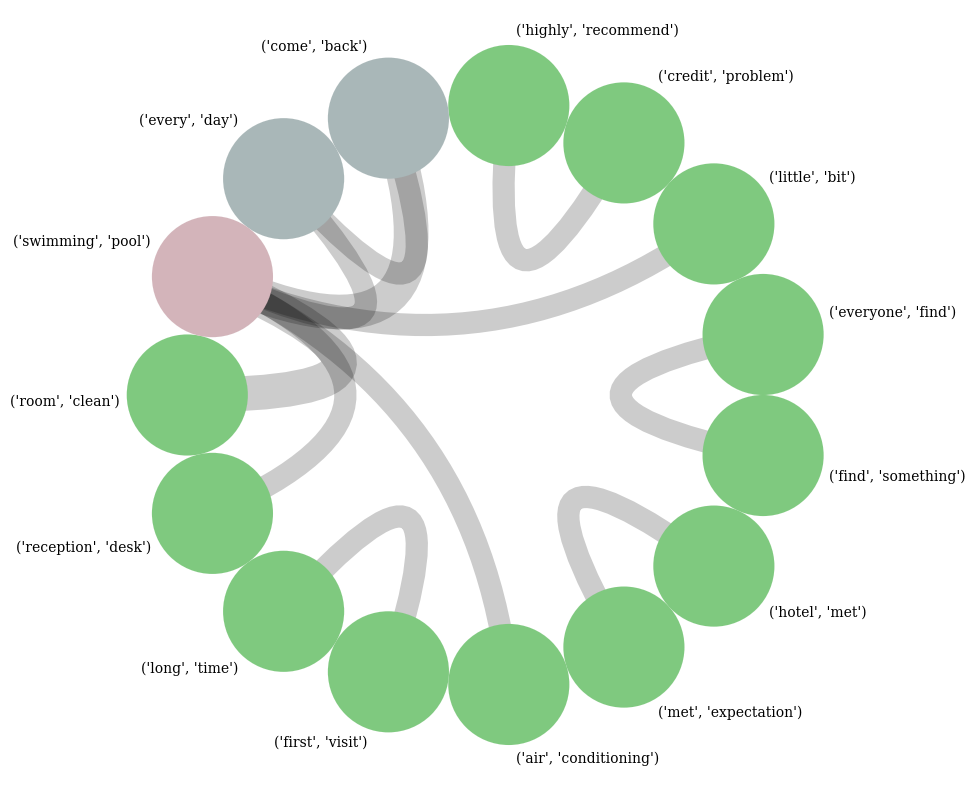

In [15]:
import networkx as nx
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from nxviz.plots import CircosPlot

G = nx.from_pandas_edgelist(graph_df, 'node1', 'node2',edge_attr=['co_occurence', 'group'])

for v in G:
    G.nodes[v]["class"] = G.degree(v)
weights = list(graph_df['co_occurence'])

# figure(figsize=(10, 10))
# nv.circos(G, edge_lw_by='co_occurence')
c = CircosPlot(G,figsize=(10, 10),
               node_labels=True,
               edge_width=weights,
               node_grouping="class",
               node_color="class")
c.draw()
plt.show()

# nv.annotate.circos_labels(G, layout='rotate')

In [16]:
#Bubble chart
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

word_count = dict(Counter(words))
word_count_df = pd.DataFrame(list(word_count.items()), columns = ['word','freq'])
words20_df = word_count_df.iloc[0:20] # top 20 most common words

word_list = words20_df['word'].tolist()
word_freq_list = words20_df['freq'].tolist()

data = {
    'bigrams': word_list,

    'frequency': word_freq_list,

    'color': ['#5A69AF', '#579E65', '#F9C784', '#FC944A',
              '#F24C00', '#00B825', '#FC944A', '#EF4026',
              'goldenrod','green', '#F9C784', '#FC944A',
              'coral', '#FC944A', '#EF4026',
              'goldenrod','green', '#F9C784', '#FC944A',
              'coral', '#5A69AF', '#579E65', '#F9C784', '#FC944A',
              '#F24C00', '#00B825', '#FC944A', '#EF4026',
              'goldenrod','green','#5A69AF', '#579E65', '#F9C784', '#FC944A',
              '#F24C00', '#00B825', '#FC944A', '#EF4026',
              'goldenrod','green']
}

In [17]:
import random
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')


bubble_chart = BubbleChart(area=data['frequency'],
                           bubble_spacing=0.1)
bubble_chart.collapse()

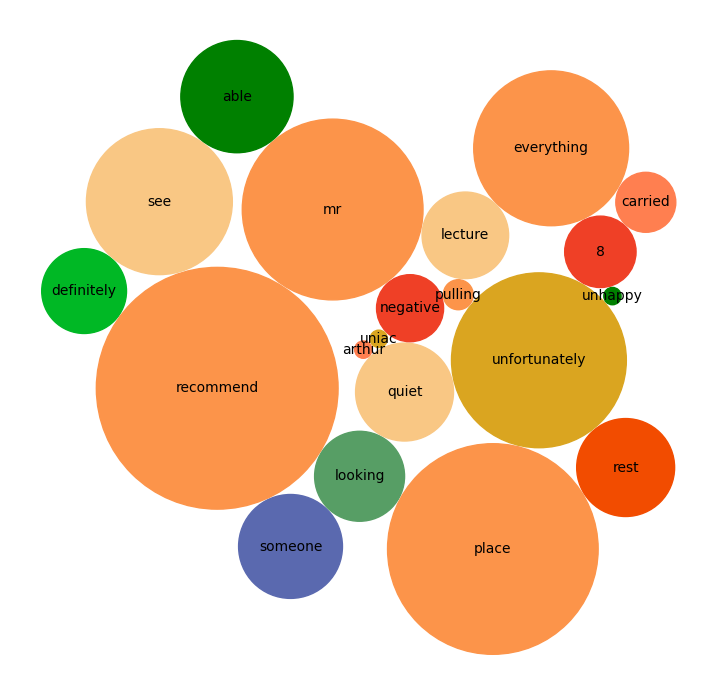

In [18]:
import matplotlib.pyplot as plt
import random

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
fig.set_size_inches(9, 13, forward=True)
bubble_chart.plot(
    ax, data['bigrams'], data['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
plt.show()